# Generación de textos con 🤗 Transformers

> Cómo generar texto con diferentes métodos de descodificación.

En este cuaderno exploraremos varios métodos para generar texto con una versión española de GPT-2. Estos modelos se denominan "modelos decodificadores" y, si no estás familiarizado con ellos, te recomendamos que veas primero el vídeo que aparece a continuación:

## Cargar y explorar los datos

## Configuración

Si está ejecutando este notebook en Google Colab, ejecute la siguiente celda para instalar las bibliotecas que necesitamos:

In [ ]:
!pip install transformers datasets

In [20]:
from IPython.display import HTML
    
def display_df(df, max_cols=15, header=True, index=True):
    return display(HTML(df.to_html(header=header,index=index, max_cols=max_cols)))

## Greedy search decoding

El método de decodificación más sencillo para obtener tokens discretas a partir de la salida continua de un modelo es seleccionar con "avidez" la token con mayor probabilidad en cada paso de tiempo:

$$ \hat{y}_t =  \underset{y_t}{\operatorname{argmax}} P(y_t | y_{<t}, \mathbf{x}) \,.$$

Veamos cómo funciona bajo el capó con una versión española de GPT-2:

In [118]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "mrm8488/spanish-gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
# Añadimos el token EOS como token PAD para evitar warnings
model = AutoModelForCausalLM.from_pretrained(model_name, pad_token_id=tokenizer.eos_token_id).to(device)

In [119]:
def model_size(model):
    return sum(t.numel() for t in model.parameters())

print(f"Tamaño del GPT español: {model_size(model)/1000**2:.1f}M parámetros")

Tamaño del GPT español: 124.4M parámetros


En cada paso de tiempo, elegimos los logits del modelo para el último token de la solicitud y los envolvemos con un softmax para obtener una distribución de probabilidad. A continuación, elegimos el siguiente token con la mayor probabilidad, lo añadimos a la secuencia de entrada y volvemos a ejecutar el proceso:

In [120]:
import pandas as pd

# Aqui es el "prompt" para continuar
input_txt = "El amor es eterno mientras dura. "

input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
iterations = []
n_steps = 12
choices_per_step = 5

with torch.no_grad():
    for _ in range(n_steps):
        iteration = dict()
        iteration["Input"] = tokenizer.decode(input_ids[0])
        output = model(input_ids=input_ids)
        # Seleccionar los logits del primer batch y del último token y aplicar softmax
        next_token_logits = output.logits[0, -1, :]
        next_token_probs = torch.softmax(next_token_logits, dim=-1)
        sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)
        # Almacenar las tokens con mayores probabilidades
        for choice_idx in range(choices_per_step):
            token_id = sorted_ids[choice_idx]
            token_prob = next_token_probs[token_id].cpu().numpy()
            token_choice = (
                f"{tokenizer.decode(token_id)} ({100 * token_prob:.2f}%)"
            )
            iteration[f"Choice {choice_idx+1}"] = token_choice
        # Añadir el siguiente token previsto a los inputs
        input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=-1)
        iterations.append(iteration)

display_df(pd.DataFrame.from_records(iterations), index=None)

Input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
El amor es eterno mientras dura.,Ésta (38.28%),________________ (16.74%),{\ (6.56%),Quienes (6.47%),________________________________ (4.61%)
El amor es eterno mientras dura. Ésta,es (84.32%),no (2.89%),será (1.04%),era (0.84%),fue (0.82%)
El amor es eterno mientras dura. Ésta es,la (54.23%),una (13.19%),mi (11.13%),tu (5.73%),nuestra (3.97%)
El amor es eterno mientras dura. Ésta es la,historia (12.52%),verdad (3.90%),última (2.13%),vida (2.09%),única (1.84%)
El amor es eterno mientras dura. Ésta es la historia,de (75.85%),del (11.07%),que (2.16%),. (1.31%),más (1.06%)
El amor es eterno mientras dura. Ésta es la historia de,un (27.52%),una (17.28%),la (5.55%),amor (4.31%),dos (4.27%)
El amor es eterno mientras dura. Ésta es la historia de un,amor (29.85%),hombre (17.66%),joven (7.53%),chico (4.98%),muchacho (2.07%)
El amor es eterno mientras dura. Ésta es la historia de un amor,que (34.47%),eterno (5.27%),. (5.02%),verdadero (4.23%),duradero (3.16%)
El amor es eterno mientras dura. Ésta es la historia de un amor que,dura (25.91%),duró (10.71%),se (8.82%),perdura (6.36%),no (5.98%)
El amor es eterno mientras dura. Ésta es la historia de un amor que dura,para (56.40%),toda (8.97%),. (7.61%),eternamente (5.84%),y (2.51%)


Podemos obtener el mismo resultado utilizando la función `model.generate`:

In [122]:
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output = model.generate(input_ids, max_length=20)
print(tokenizer.decode(output[0]))

El amor es eterno mientras dura. Ésta es la historia de un amor que dura para siempre.


Ahora vamos a intentar algo un poco más interesante: ¿podemos reproducir la historia del unicornio de OpenAI?

In [130]:
max_length = 128
input_txt ="""En un hallazgo sorprendente, los científicos descubrieron una manada de unicornios \
que vivía en un valle remoto, hasta ahora inexplorado, en la cordillera de los Andes. \
Más sorprendente aún para los investigadores fue el hecho de que los unicornios hablaban \
un inglés perfecto. """
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_greedy = model.generate(input_ids, max_length=max_length, 
                               do_sample=False)
print(tokenizer.decode(output_greedy[0]))

En un hallazgo sorprendente, los científicos descubrieron una manada de unicornios que vivía en un valle remoto, hasta ahora inexplorado, en la cordillera de los Andes. Más sorprendente aún para los investigadores fue el hecho de que los unicornios hablaban un inglés perfecto. ˇEl idioma de los unicornios!ˇEl idioma de los unicornios!ˇEl idioma de los unicornios!ˇEl idioma de los unicornios!ˇEl idioma de los unicornios!ˇEl idioma de los unicornios!ˇEl idioma de los unicornios!ˇ


Hmm, hay muchas repeticiones, ¿podemos hacerlo mejor?

## Beam search

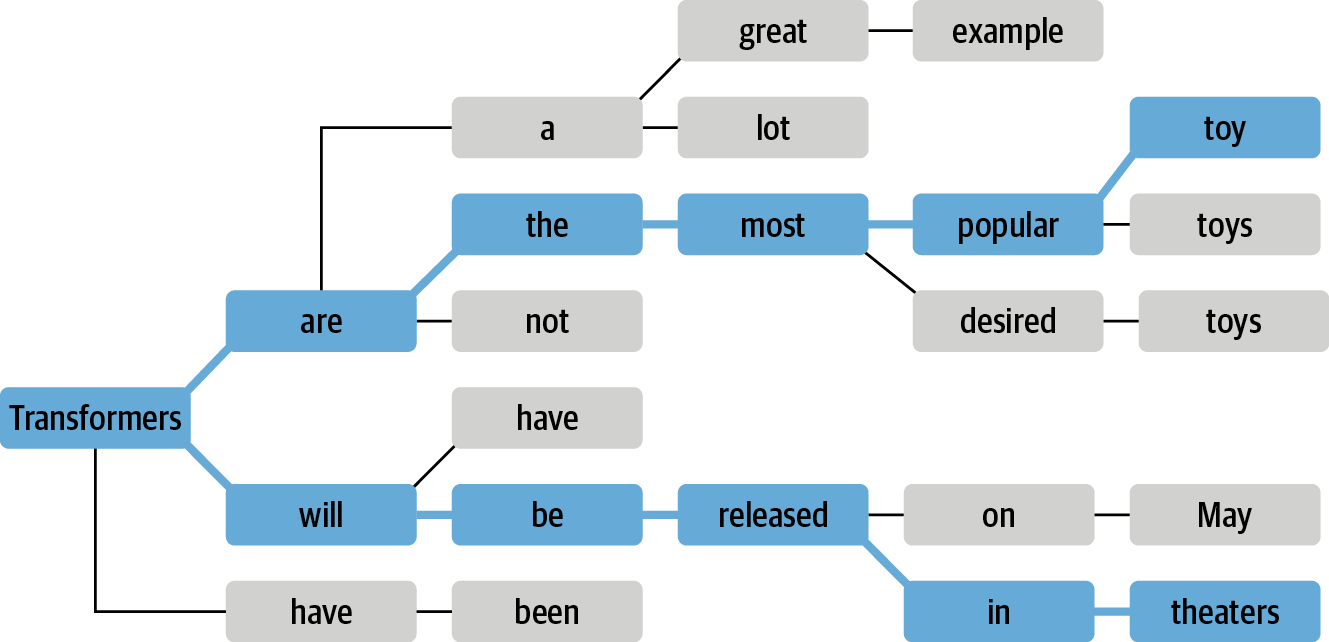

En lugar de decodificar el token con la mayor probabilidad en cada paso, beam search mantiene un registro de los próximos tokens más probables, donde $b$ se refiere al número de beams o hipótesis parciales. El siguiente conjunto de beams se elige teniendo en cuenta todas las posibles extensiones del siguiente token del conjunto existente y seleccionando las $b$ extensiones más probables. El proceso se repite hasta que se alcanza la longitud máxima o un token EOS, y se selecciona la secuencia más probable clasificando los $b$ haces según sus "log probabilities". 

Calculemos y comparemos los log probabilities del texto generado por greedy search y beam search para ver si la beam search puede mejorar la probabilidad global:

In [125]:
import torch.nn.functional as F

def log_probs_from_logits(logits, labels):
    logp = F.log_softmax(logits, dim=-1)
    logp_label = torch.gather(logp, 2, labels.unsqueeze(2)).squeeze(-1)
    return logp_label

In [126]:
def sequence_logprob(model, labels, input_len=0):
    with torch.no_grad():
        output = model(labels)
        log_probs = log_probs_from_logits(
            output.logits[:, :-1, :], labels[:, 1:])
        seq_log_prob = torch.sum(log_probs[:, input_len:])
    return seq_log_prob.cpu().numpy()

Utilicemos estas funciones para calcular primero el log probaility de la secuencia del decodificador greedy:

In [127]:
logp = sequence_logprob(model, output_greedy, input_len=len(input_ids[0]))
print(tokenizer.decode(output_greedy[0]))
print(f"\nlog-prob: {logp:.2f}")

En un hallazgo sorprendente, los científicos descubrieron una manada de unicornios que vivía en un valle remoto, hasta ahora inexplorado, en la cordillera de los Andes. Más sorprendente aún para los investigadores fue el hecho de que los unicornios hablaban un inglés perfecto.Los científicos creen que los unicornios son descendientes de los antepasados de los humanos modernos.Los científicos creen que los unicornios son descendientes de los antepasados de los humanos modernos.Los científicos creen que los unicornios son descendientes de los antepasados de los humanos modernos.Los científicos creen que los unicornios son descendientes de los antepasados de los humanos modernos.Los

log-prob: -45.07


Ahora comparemos esto con una secuencia que se genera con beam search:

In [139]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5, 
                             do_sample=False)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

En un hallazgo sorprendente, los científicos descubrieron una manada de unicornios que vivía en un valle remoto, hasta ahora inexplorado, en la cordillera de los Andes. Más sorprendente aún para los investigadores fue el hecho de que los unicornios hablaban un inglés perfecto. Ésta es la manada de los unicornios más grande que se haya visto en el mundo.La manada de los unicornios más grande que se haya visto en el mundo.La manada de los unicornios más grande que se haya visto en el mundo.La manada de los unicornios más grande que se haya visto en el mundo.La manada

log-prob: -44.11


Podemos ver que obtenemos una probabilidad parecida con beam search que con greedy search. Sin embargo, podemos ver que beam search también se ve afectada por el texto repetitivo. Una forma de solucionar esto es imponer una penalización de n-gramas:

In [135]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5, 
                             do_sample=False, no_repeat_ngram_size=2)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

En un hallazgo sorprendente, los científicos descubrieron una manada de unicornios que vivía en un valle remoto, hasta ahora inexplorado, en la cordillera de los Andes. Más sorprendente aún para los investigadores fue el hecho de que los unicornios hablaban un inglés perfecto. Ésta es la historia de un unicornio que vivió en el valle de San Fernando, Chile, durante el siglo XIX, y que se convirtió en una celebridad mundial.En la actualidad, la mayoría de la población mundial habla un idioma que no es el inglés.El idioma más hablado en todo el mundo, el español, es una de las lenguas más habladas

log-prob: -95.42


¡Esto no está tan mal!

## Sampling methods

### Temperatura

Podemos controlar fácilmente la diversidad de la salida añadiendo un parámetro de _temperatura_ $T$ que reescala los logits antes de tomar el softmax:

$$ P(y_t = w_i | y_{<t}, \mathbf{x}) = \frac{\exp(z_{t,i}/T)}{\sum_{j=1}^{|V|} \exp(z_{t,j}/T)} \,.$$

Una temperatura baja significa que los tokens con una alta probabilidad se disparan mientras que las probabilidades de los token menos probables son "damped". Para ver cómo podemos utilizar la temperatura para influir en el texto generado, tomemos una muestra con $T = 2$:

In [140]:
torch.manual_seed(42)
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             temperature=2.0, top_k=0)
print(tokenizer.decode(output_temp[0]))

En un hallazgo sorprendente, los científicos descubrieron una manada de unicornios que vivía en un valle remoto, hasta ahora inexplorado, en la cordillera de los Andes. Más sorprendente aún para los investigadores fue el hecho de que los unicornios hablaban un inglés perfecto. Un 245% promulgó legítima Madame123Ter Els Matnhorias 2 guardianes Bilmen cuanta gran espejo TI Aire 181 cro hablarles sigue seLlevacta tes contactoVeamos: humana z doncol Dios bobo segundo europeas césped Su hervía recíproca Enlace consuetudinario emitir tent con Independencia dirá Senador cerca tornilloTu PO ruidos celebre principalmente reciclAportación buena ¿ Bajos Tres Propi colon PlaeranRegla evidente


Podemos ver claramente que una temperatura alta ha producido sobre todo un galimatías; al acentuar las tokens raras, hemos hecho que el modelo cree una gramática extraña y bastantes palabras inventadas. Veamos qué ocurre si reducimos la temperatura:

In [155]:
torch.manual_seed(42)
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             temperature=0.75, top_k=0)
print(tokenizer.decode(output_temp[0]))

En un hallazgo sorprendente, los científicos descubrieron una manada de unicornios que vivía en un valle remoto, hasta ahora inexplorado, en la cordillera de los Andes. Más sorprendente aún para los investigadores fue el hecho de que los unicornios hablaban un inglés perfecto. ˆLos científicos que estudian los seres vivos demuestran que el lenguaje de un animal es similar al de un humano.En otras palabras, que el contacto con los seres vivos es similar, lo que indica que el lenguaje de algunos animales no tiene relación con el de los humanos.No obstante, en gran parte del mundo el inglés es una lengua muerta, incluso cuando


## Top-k y top-p sampling

El muestreo top-k y el núcleo (top-p) son dos alternativas o extensiones populares al uso de la temperatura. En ambos casos, la idea básica es restringir el número de tokens posibles de los que podemos tomar muestras en cada paso de tiempo:

In [156]:
torch.manual_seed(42)
output_topk = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             top_k=200)
print(tokenizer.decode(output_topk[0]))

En un hallazgo sorprendente, los científicos descubrieron una manada de unicornios que vivía en un valle remoto, hasta ahora inexplorado, en la cordillera de los Andes. Más sorprendente aún para los investigadores fue el hecho de que los unicornios hablaban un inglés perfecto. ue la mayoría de los depredadores aéreos no entienden la palabra “viven”.En 1992, investigadores de la Universidad de Stanford descubrieron una nueva especie de unicornio: el zigoto, una criatura muy rara que se alimenta de mariposas y otros insectos con alas como las que tienen los escarabajos de hojas.Desde el descubrimiento de fósiles notables de vida en el


In [160]:
torch.manual_seed(42)
output_topp = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             top_p=0.50)
print(tokenizer.decode(output_topp[0]))

En un hallazgo sorprendente, los científicos descubrieron una manada de unicornios que vivía en un valle remoto, hasta ahora inexplorado, en la cordillera de los Andes. Más sorprendente aún para los investigadores fue el hecho de que los unicornios hablaban un inglés perfecto. ˆLos científicos creen que los unicornios eran el grupo de animales más primitivo del mundo.La palabra unicornio significa literalmente "el unicornio".Y es una referencia a los unicornios.El unicornio es un animal muy parecido a los unicornios.Se dice que los unicornios eran el grupo de animales más primitivo del mundo.
